In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree, ensemble 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

from IPython.display import display as dsp
from IPython.display import Image

import pydotplus
import graphviz

In [2]:
gps_raw = pd.read_csv('data/googleplaystore.csv')
gps_raw.dropna(inplace = True)
dsp(gps_raw.head())

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
categorical = gps_raw.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

App
8190
Category
33
Reviews
5990
Size
413
Installs
19
Type
2
Price
73
Content Rating
6
Genres
115
Last Updated
1299
Current Ver
2638
Android Ver
31


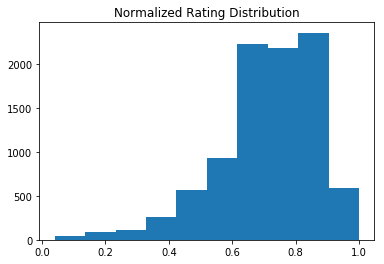

In [4]:
Y = gps_raw['Rating']

Y_normed = (Y / max(Y)) ** 2

plt.hist(Y_normed)
plt.title('Normalized Rating Distribution')
plt.show()

In [5]:
#Create Columns
data = gps_raw[['Category', 'Rating', 'Installs', 'Content Rating', 'Genres']]

#Cast columns w/numeric data to a numeric type
data['Reviews'] = gps_raw['Reviews'].astype(int)
data['Price'] = gps_raw['Price'].str.replace('$', '').astype(float)

#Create dummy variables for binary features
data = pd.get_dummies(data)

print('Final dataframe shape:\n{}'.format(data.shape))

Final dataframe shape:
(9360, 176)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
#Create Features
X = data.drop(columns = ['Rating'])
print('Original Shape: ', X.shape)
print(type(Y))

Original Shape:  (9360, 175)
<class 'pandas.core.series.Series'>


In [7]:
#Feature Selection
X_sel = SelectKBest(f_regression, k = 20).fit_transform(X, Y)

print('Final shape: ', X_sel.shape)
print('Final Type: ', type(X_sel))

Final shape:  (9360, 20)
Final Type:  <class 'numpy.ndarray'>


In [8]:
def modelValidate(mod, X, Y):
    print('Model Score: ',mod.score(X, Y))
    
    print('\nFold Scores:\n', cross_val_score(mod, X, Y, cv = 5))

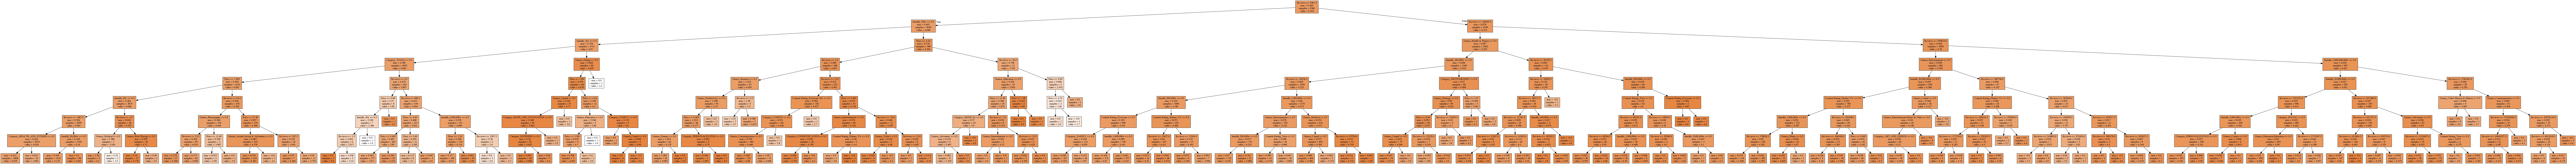

In [9]:
#Decision Tree Regressor
dt = tree.DecisionTreeRegressor(
    max_depth = 8
)

dt.fit(X, Y)

#Render Tree
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X.columns,
    class_names=Y.unique(),
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
dsp(Image(graph.create_png()))

In [10]:
modelValidate(dt, X, Y)

Model Score:  0.20128952739572614

Fold Scores:
 [-0.06763954 -0.13774858  0.08555937 -0.16286005 -0.00121696]


In [14]:
rnd = ensemble.RandomForestRegressor(n_estimators = 100)

rnd.fit(X, Y)

modelValidate(rnd, X, Y)

Model Score:  0.8169746349676043

Fold Scores:
 [-0.03607195  0.02578336  0.02150557 -0.04377089 -0.08292289]


In [12]:
#Less overfitting, invest more time into.

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X, Y)

modelValidate(gbr, X, Y)

Model Score:  0.1890918164394284

Fold Scores:
 [0.04539394 0.04084236 0.12450808 0.05589761 0.06923035]


In [15]:
print('Depth 8 Decision Tree Regressor:\n')
modelValidate(dt, X, Y)

print('\n\nRandom Forest Regressor:\n')
modelValidate(rnd, X, Y)

print('\n\nGradient Boosting Regressor:\n')
modelValidate(gbr, X, Y)

Depth 8 Decision Tree Regressor:

Model Score:  0.20128952739572614

Fold Scores:
 [-0.06564287 -0.1382148   0.08393467 -0.16745063 -0.00095477]


Random Forest Regressor:

Model Score:  0.8169746349676043

Fold Scores:
 [-0.04248717  0.04016703  0.01754413 -0.04133862 -0.08114299]


Gradient Boosting Regressor:

Model Score:  0.1890918164394284

Fold Scores:
 [0.04274998 0.04089594 0.12388435 0.055932   0.06931038]


# Feature Selection

__Make sure they have something to do with the outcome__
__Algs only choos a limited nmbr of features__


Corr Matrix
    -Less useful for categorical features

Select K-Best
    -Sklearn Model
    -How many features you want to retain. (k num)
    -ANOVA filtering
    
Put data through tree based model and return feature importance. Iterate again.

PCA

### Also Good For Classifiers.

Hyper Parameters
    -N_estimators, depth ect.
    -Accuracy goes up w/ estimators.
    
Look at the 